2025.02.22, Zhang Chao<br>
Show the cooling dynamics from 2001 to 2020 at the pixel scale and monthly scale

In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
import numpy as np
import xarray as xr
import geopandas as gpd
import seaborn as sns
import pymannkendall as mk
import matplotlib.lines as mlines
import statsmodels.api as sm
import sys
import matplotlib as mpl
import os
from cartopy.feature import ShapelyFeature
import matplotlib.colors as mcolors
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../')))
from utils import getSigFlag,compute_mk_trend, stats_regionratio
sys.path.append('/home/climate/chaoz/code/utils/')
from plot_utils import plot_settings, uneven_cmap
from da_utils import get_trend

---Start to load data files---

In [2]:
os.chdir('/home/climate/chaoz/project/03Irr_Ts_CN/processed/')

# Below two input files were produced by './2_process/06_resampleto05d.ipynb'
dLSTday_Yr_05d = xr.open_dataset('delta_LSTday_Yr_CN_2001_2020_05d.nc')
dLSTnight_Yr_05d = xr.open_dataset('delta_LSTnight_Yr_CN_2001_2020_05d.nc')
# Below two input files are produced by './2_process/05_region_mean.ipynb'
dLSTday_Mn_regionmean   = pd.read_csv('regionmean_dLSTday_Mn.csv')
dLSTnight_Mn_regionmean = pd.read_csv('regionmean_dLSTnight_Mn.csv')

shp_cn = gpd.read_file('../shapefile/ChinaAll.shp')
shp_nanhai = gpd.read_file('../shapefile/Nanhai.shp')
shp_climzone = gpd.read_file('../shapefile/ClimateZone_3.shp')

Prepare to do necessary calculations

In [3]:
# plotting functions
def getSigFlag(p):
    """Get the significance sign (star)

    Args:
        p (float32): p-value

    Returns:
        str: significance sign
    """
    strSig = ''
    if p<0.05:
        strSig = '**'
    elif p<0.1:
        strSig = '*'
    else:
        strSig = ''
    return strSig


def compute_mk_trend(y):
    result = mk.original_test(y.dropna()) # Mann-Kendall test
    return result.slope*10, result.p


def get_df_dLST_Mn_trends(df0):
    df = df0.copy()

    # Convert 'time' column to datetime format
    df['time'] = pd.to_datetime(df['time'])
    
    # Extract month and year
    df['month'] = df['time'].dt.month
    df['year'] = df['time'].dt.year
    
    # Group by month and compute trends within each month
    slope_list = []
    pval_list = []
    
    
    for month in range(1,13): # Loop through months 1 to 12
        df_month = df[df['month'] == month].sort_values(by='year', ascending=True)
        
        trends = df_month[['China', 'Arid', 'Semi', 'Humid']].apply(compute_mk_trend).T
        trends.columns=['slope','pval']
        
        slopes = trends['slope'].copy()
        slopes['month'] = month
        slope_list.append(slopes)
        
        pvals = trends['pval'].copy()
        pvals['month'] = month
        pval_list.append(pvals)
        
    df_slope = pd.DataFrame(slope_list).reset_index(drop=True)
    df_pval = pd.DataFrame(pval_list).reset_index(drop=True)
    
    # Reorder columns
    df_slope = df_slope[['month', 'China', 'Arid', 'Semi', 'Humid']]
    df_pval = df_pval[['month', 'China', 'Arid', 'Semi', 'Humid']]

    return df_slope, df_pval

In [4]:
df_Day_Mn_slope,df_Day_Mn_pval     = get_df_dLST_Mn_trends(dLSTday_Mn_regionmean)
df_Night_Mn_slope,df_Night_Mn_pval = get_df_dLST_Mn_trends(dLSTnight_Mn_regionmean)

In [5]:
# Calculate the annual and monthly trend of dLST
dLSTday_Yr_05d_trend   = get_trend(dLSTday_Yr_05d,   'Ts')
dLSTnight_Yr_05d_trend = get_trend(dLSTnight_Yr_05d, 'Ts')

# Get the regional statistics: proportion of positive and negative slope pixels
stats_day   = stats_regionratio(dLSTday_Yr_05d_trend  ,shp_climzone)
stats_night = stats_regionratio(dLSTnight_Yr_05d_trend,shp_climzone)


Plotting functions

In [6]:
def plot_trend_map(fig, pos, ds, extent,shape_cn,shape_nanhai,levels, mycmap, title,No):
    lambert_proj = ccrs.LambertConformal(central_longitude=105, central_latitude=35, standard_parallels=(25, 47))
    ax = fig.add_axes(pos, projection=lambert_proj, frame_on=False)
    # Define Lambert Conformal projection (customized for China)

    ds.slope.plot(ax=ax, levels=levels,transform=ccrs.PlateCarree(),#lambert_proj
                     cmap=mycmap, add_colorbar=False, rasterized=True) #vmax=vmax, vmin=vmin,
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    # ax1.add_feature(fea_hpa, edgecolor='k', linewidth=0.8)
    fea_cn = ShapelyFeature(shape_cn.geometry, crs=ccrs.PlateCarree())
    fea_nanhai = ShapelyFeature(shape_nanhai.geometry, crs=ccrs.PlateCarree())
    ax.add_feature(fea_cn,facecolor='none',linewidth=.6)
    ax.add_feature(fea_nanhai,facecolor='none',linewidth=.6)
    
    lons, lats = np.meshgrid(ds.lon, ds.lat)
    area = np.where(ds.p < 0.1)
    ax.scatter(lons[area], lats[area], c='k', alpha=0.5, s=0.5, transform=ccrs.PlateCarree())
    ax.text(0.01, 0.95, No, transform=ax.transAxes, c='k', weight='bold', fontsize=18)
    ax.set_title(title)#,y=0.98
    # Add the South China Sea map
    hx,vx = 0.0381,0.10
    pos_scs = [ax.get_position().x1-hx,ax.get_position().y0,hx,vx]
    ax_scs = fig.add_axes(pos_scs,projection=lambert_proj,frame_on=True)
    ax_scs.add_feature(fea_cn    ,facecolor='none',linewidth=.6)
    ax_scs.add_feature(fea_nanhai,facecolor='none',linewidth=.6)
    ax_scs.set_extent([107, 120,3,23], crs=ccrs.PlateCarree())
    
    return ax


def plot_lat_stats(fig,pos,ds1,ds2,ylim,No):
    ax = fig.add_axes(pos)
    colors = ['#0a6f67','#955910']
    lat_stats = ds1.quantile([0.25,0.50,0.75], dim='lon')
    lat = lat_stats.lat
    p25 = lat_stats.sel(quantile=0.25)
    p50 = lat_stats.sel(quantile=0.50)
    p75 = lat_stats.sel(quantile=0.75)
    
    # Fill the region between the 25th and 75th percentiles
    ax.fill_betweenx(lat,p25,p75,color=colors[0],alpha=0.3)
    # Plot the median (50th percentile) as a solid line
    ax.plot(p50,lat,color=colors[0],linewidth=1.2)
    
    lat_stats = ds2.quantile([0.25,0.50,0.75], dim='lon')
    lat = lat_stats.lat
    p25 = lat_stats.sel(quantile=0.25)
    p50 = lat_stats.sel(quantile=0.50)
    p75 = lat_stats.sel(quantile=0.75)
    
    # Fill the region between the 25th and 75th percentiles
    ax.fill_betweenx(lat,p25,p75,color=colors[1],alpha=0.3)
    # Plot the median (50th percentile) as a solid line
    ax.plot(p50,lat,color=colors[1],linewidth=1.2)
    
    ax.axvline(0,0,1,color='k',linewidth=1,linestyle='--')
    # ax.text(0.1,0.98,'Day'  ,transform = ax.transAxes,fontsize=12,color=colors[0])
    # ax.text(0.1,0.92,'Night',transform = ax.transAxes,fontsize=12,color=colors[1])
    ax.yaxis.tick_right()
    ax.set_ylim(ylim)
    ax.set_xlim([-0.025,0.025])
    ax.set_xticks([-0.02,0,0.02],[-0.2,0,0.2])
    ax.set_yticks([20,30,40,50],['20N','30N','40N','50N'])
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    # Create custom legend handles
    handles = [
        mlines.Line2D([], [], color=colors[0], linestyle='-', label='Day'),
        mlines.Line2D([], [], color=colors[1], linestyle='-', label='Night'),
    ]
    
    ax.legend(handles=handles, ncol=1, loc='upper right',frameon=False,
                  handlelength=1.0, handleheight=0.5, columnspacing = 1,handletextpad=0.5,
                  bbox_to_anchor=(1.1, 1.05))
    
    return ax


def plot_bar_regionstats(fig,pos,stats):
    ax = fig.add_axes(pos)
    ax.patch.set_alpha(0)
    cn,arid,semi,humid = stats[0],stats[1],stats[2],stats[3]
    colors = ['#1a8076','#be7d27','#BFBFBF']
    width = 1.3
    x = [1, 3, 5]
    ax.bar(x, [ arid[0], semi[0], humid[0]], width, color=colors[2])
    ax.bar(x, [ arid[2], semi[2], humid[2]], width, color=colors[0])
    ax.bar(x, [-arid[1],-semi[1],-humid[1]], width, color=colors[2])
    ax.bar(x, [-arid[3],-semi[3],-humid[3]], width, color=colors[1])
    # print(p1[0], p2[0],p3[0])
    ax.axhline(y=0.0, c="k", ls="-", lw=1)
    ax.set_xticks(x,['Arid','Semi','Humid'],fontsize=10,rotation=30)
    ax.text(0.08,0.75,'%.0f%%' % cn[2], c=colors[0], transform=ax.transAxes)
    ax.text(0.08,0.05,'%.0f%%' % cn[3], c=colors[1], transform=ax.transAxes)
    ax.set_ylim(-37,37)

    ax.set_yticks([-25,0,25], ['25','0','25'],fontsize=10)
    ax.set_ylabel('Frequency [%]',fontsize=10)
    
    ax.tick_params(axis='x', bottom=True,length=0)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['right'].set_visible(False)
    
    return ax


def plot_heatmap(fig, pos, df_slope,df_pval,cmap,norm):
    ax = fig.add_axes(pos)

    # Create annotation matrix for significance
    annot_matrix = df_pval.set_index('month').map(getSigFlag).T  # Transpose to match shape
    
    # Convert df_slope to numpy for heatmap plotting
    slope_matrix = df_slope.set_index('month').T  # Transpose to match month on x-axis
    xticklabels = ['J','F','M','A','M','J','J','A','S','O','N','D']
    sns.heatmap(slope_matrix, annot=annot_matrix, fmt='', cmap=cmap, norm = norm,cbar=False,
                linewidths=0.5, cbar_kws={'label': 'Trend Slope'},#annot_kws={'va':'center'},
                xticklabels=xticklabels, yticklabels=slope_matrix.index, ax=ax)
    
    ax.tick_params(axis='x',length=0)
    ax.tick_params(axis='y',length=0)
    
    return ax


def pie_plot(ax,A,B,cmap,norm):
    radii = [0.3, 0.6, 0.9, 1.2]
    width = 0.29
    month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    # Settings
    columns = ['China', 'Arid', 'Semi', 'Humid']
    # Store wedge angles of outermost ring
    outer_angles = []
    
    # Draw each ring
    for j, (col, radius) in enumerate(zip(columns, radii)):
        slope_vals = A[col].values
        pvals = B[col].values
        colors = cmap(norm(slope_vals))
    
        wedges, _ = ax.pie(
            np.ones(12),
            colors=colors,
            radius=radius + width,
            startangle=90,
            counterclock=False,
            wedgeprops=dict(width=width, edgecolor='w')
        )
    
        # Significance annotation
        for i, (wedge, p) in enumerate(zip(wedges, pvals)):
            angle = (wedge.theta2 + wedge.theta1) / 2
            x = np.cos(np.radians(angle)) * (radius + width / 2)
            y = np.sin(np.radians(angle)) * (radius + width / 2)
            sig = "**" if p < 0.05 else "*" if p < 0.10 else ""
            if sig:
                ax.text(x, y, sig, ha='center', va='center', fontsize=11, color='white')# fontweight='bold',
    
        # Save angles from outermost ring
        if j == len(columns) - 1:
            outer_angles = [(w.theta1 + w.theta2) / 2 for w in wedges]
    
    # Month labels at outermost ring
    label_radius = radii[-1] + width * 1.7
    for angle, month in zip(outer_angles, month_labels):
        x = np.cos(np.radians(angle)) * label_radius
        y = np.sin(np.radians(angle)) * label_radius
        ax.text(x, y, month, ha='center', va='center', fontsize=12)
    
    # ax.text(0.0,0.99,No,transform=ax.transAxes,fontsize=14,weight='bold')
    return ax


# Function to add color bar for the main maps
def add_colorbar_horizontal(ax, mycmap, mynorm, levels,ticklabels):
    cb1 = mpl.colorbar.ColorbarBase(ax=ax, cmap=mycmap, norm=mynorm,
                                    orientation='horizontal',
                                    ticks=levels,extend='neither') 
    ax.set_xticklabels(ticklabels)
    ax.text(1.13, 0.1, 'Slope [K/decade]', ha='center', #va='center', 
            transform=ax.transAxes,fontsize=12)


def add_colorbar_vertical(ax, mycmap, mynorm, levels,ticklabels):
    cb1 = mpl.colorbar.ColorbarBase(ax=ax, cmap=mycmap, norm=mynorm,
                                    orientation='vertical',
                                    ticks=levels,extend='neither') 
    ax.set_yticklabels(ticklabels)
    ax.set_ylabel('Slope [K/decade]',labelpad=5)
    ax.tick_params(axis='y',right=True,length=0)


def draw_ring_dir_legend(ax):
    ax.patch
    # Labels for the four segments
    labels = ['China', 'Arid', 'Semi', 'Humid']
    n_segments = len(labels)
    
    # Segment boundaries (yticks at each boundary)
    y_ticks = np.linspace(0, 1, n_segments + 1)  # e.g., [0. , 0.25, 0.5, 0.75, 1. ]
    
    # Midpoints for labeling between ticks
    y_mids = (y_ticks[:-1] + y_ticks[1:]) / 2
    
    # Draw each vertical segment
    x_center = 0  # x-location of the vertical line
    for i in range(n_segments):
        ax.plot([x_center, x_center], [y_ticks[i], y_ticks[i+1]], color='black', linewidth=1)
        ax.plot([x_center, 0.05], [y_ticks[i], y_ticks[i]], color='black', linewidth=1)
    
    ax.arrow(0.0, 1.0, 0.0, 0.0, head_width=0.05, head_length=0.05,fc='gray',ec='k')
    # Set yticks at segment boundaries
    ax.set_yticks([])
    
    # Replace tick labels with segment labels at midpoints
    ax.set_yticklabels([])
    for y, label in zip(y_mids, labels):
        ax.text(x_center + 0.03, y, label, va='center', ha='left', fontsize=12)
    
    # Final formatting
    ax.set_xlim(-0.1, 0.4)
    ax.set_ylim(-0.05, 1.1)
    ax.set_xticks([])
    # ax.tick_params(axis='y', direction='out', length=5)
    ax.spines[['top', 'right', 'left', 'bottom']].set_visible(False)
    
    ax.text(-0.05, -0.08, 'Inner', va='center', ha='left', fontsize=12)
    ax.text(-0.05, 1.1, 'Outer', va='center', ha='left', fontsize=12)

Plot figures

0.41 0.4893961275245742


/home/climate/chaoz/.conda/envs/geo_env/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


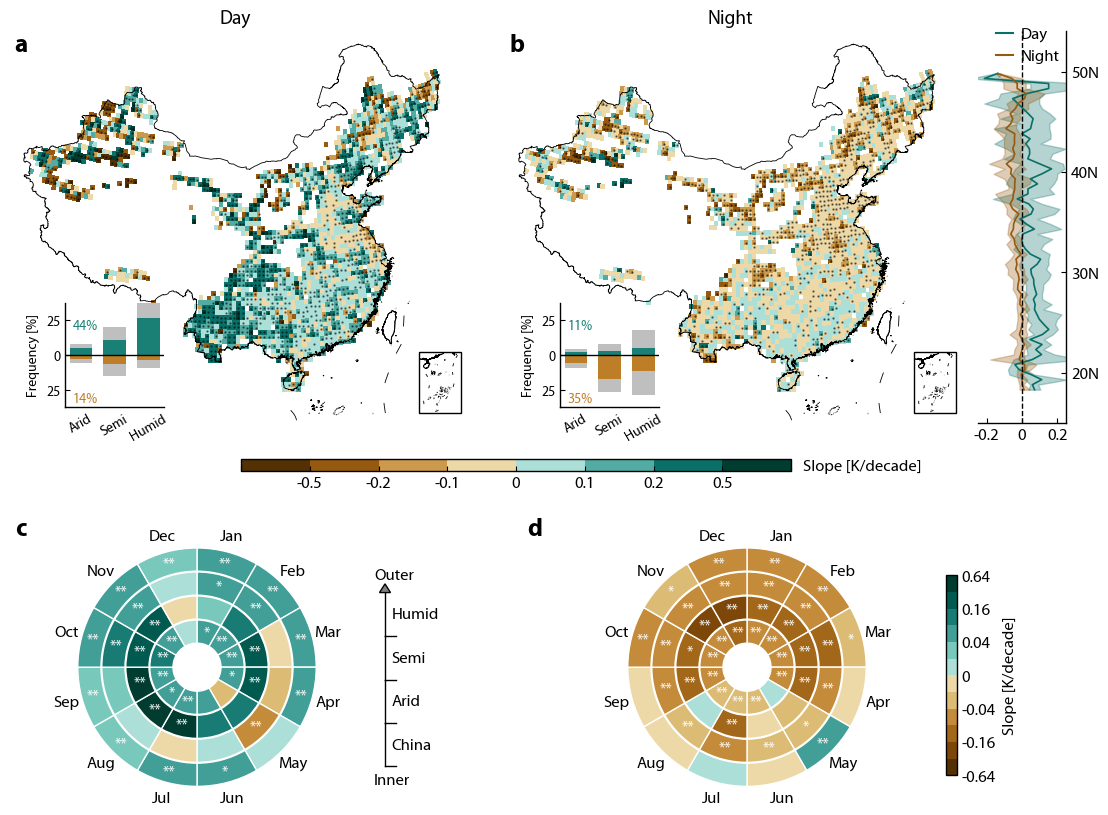

In [8]:
colors1 = plt.cm.BrBG(np.linspace(0.00, 0.40, 128))  # 128* seismic bwr PRGn
colors2 = plt.cm.BrBG(np.linspace(0.60, 1.00, 128))  # 128* seismic
colors = np.vstack((colors1, colors2))
mycmap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

plevel = np.array([0,0.01,0.02,0.05,0.25])
nlevel = -1 * plevel[1:]
levels1 = np.concatenate([nlevel[::-1], plevel])
cmap1, norm1 = uneven_cmap(levels1, cmap=mycmap)#RdYlBu_r 'BrBG'

plevel = np.array([0,0.02,0.04,0.08,0.16,0.32,0.64])
nlevel = -1 * plevel[1:]
levels2 = np.concatenate([nlevel[::-1], plevel])
cmap, norm = uneven_cmap(levels2, cmap=mycmap)
ticklabels2=['-0.64','','-0.16','','-0.04','',
             '0','','0.04','','0.16','','0.64']


# Plot
fig=plt.figure(figsize=(11,8))
plot_settings()
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

extent = [80, 127,15,54]
hx2, vx2 = 0.41, 0.55 # width, height
pos51 = [0.00, 0.45, hx2, vx2]
pos52 = [0.45, 0.45, hx2, vx2]
ax51 = plot_trend_map(fig, pos51, dLSTday_Yr_05d_trend  , extent,shp_cn,shp_nanhai,levels1, cmap1,'Day', 'a')
ax52 = plot_trend_map(fig, pos52, dLSTnight_Yr_05d_trend, extent,shp_cn,shp_nanhai,levels1, cmap1,'Night', 'b')

print(ax51.get_position().width, ax51.get_position().height)

# Plot the latitudinal statistics on the right of the map
pos51_r = [ax51.get_position().x1+0.02,ax51.get_position().y0,0.08,ax51.get_position().height]
pos52_r = [ax52.get_position().x1+0.02,ax52.get_position().y0,0.08,ax52.get_position().height]

# ax51_r = plot_lat_stats(fig,pos51_r,dLSTday_Yr_05d_trend.slope  ,[extent[2],extent[3]],' ')
ax52_r = plot_lat_stats(fig,pos52_r
                        ,dLSTday_Yr_05d_trend.slope
                        ,dLSTnight_Yr_05d_trend.slope,[extent[2],extent[3]],' ')

# Plot the regional statistics at the left-bottom corner
pos51_lb = [ax51.get_position().x0+0.05,ax51.get_position().y0+0.02,0.09,0.13]
pos52_lb = [ax52.get_position().x0+0.05,ax52.get_position().y0+0.02,0.09,0.13]
ax51_lb  = plot_bar_regionstats(fig,pos51_lb,stats_day)
ax52_lb  = plot_bar_regionstats(fig,pos52_lb,stats_night)

pos_cbar1 = [ax51.get_position().x1-0.2, ax51.get_position().y0-0.06,
             0.5, 0.015]
ticklabels1 = ['','-0.5','-0.2','-0.1','0','0.1','0.2','0.5','']
add_colorbar_horizontal(fig.add_axes(pos_cbar1), cmap1, norm1, levels1, ticklabels1)

height = 0.25
pos3 = [0.02,0.05,0.30,height]
pos4 = [0.52,0.05,0.30,height]
ax3 = pie_plot(fig.add_axes(pos3),df_Day_Mn_slope,df_Day_Mn_pval,cmap,norm)
ax4 = pie_plot(fig.add_axes(pos4),df_Night_Mn_slope,df_Night_Mn_pval,cmap,norm)

pos3_1 = [ax3.get_position().x1 + 0.06, 0.04,
          0.1,height]
draw_ring_dir_legend(fig.add_axes(pos3_1))

pos_cb = [ax4.get_position().x1+0.09,0.04,0.01,height]
ax_cb = fig.add_axes(pos_cb)
add_colorbar_vertical(ax_cb, cmap, norm, levels2,ticklabels2)

fig.text(0.005,0.34,'c',weight='bold',fontsize=18)
fig.text(0.47,0.34,'d',weight='bold',fontsize=18)

# plt.savefig('../figures/Figure_02.png',dpi=300)
plt.savefig('../figures/Figure_02.pdf')